# MNIST handwritten digits classification with CNNs

## Advanced topics on machine learning
Mauricio A. Álvarez Phd

TA:
Cristian D. Guarnizo PhD and Hernan F. García PhD (c)

In this notebook, we'll train a convolutional neural network (CNN, ConvNet) to classify MNIST digits using Keras (with either Theano or Tensorflow as the compute backend).  Keras version $\ge$ 2 is required. 

This notebook builds on the MNIST-MLP notebook, so the recommended order is to go through the MNIST-MLP notebook before starting with this one. 

First, the needed imports. Note that there are a few new layers compared to the MNIST-MLP notebook: Flatten, MaxPooling2D, Conv2D.

In [0]:
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D 
from keras.utils import np_utils
from keras import backend as K

from distutils.version import LooseVersion as LV
from keras import __version__

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using TensorFlow backend.


Using Keras version: 2.2.4 backend: tensorflow


Let's load the MNIST or Fashion-MNIST dataset.

In [0]:
from keras.datasets import mnist, fashion_mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
nb_classes = 10

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one-hot encoding:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print()
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Y_train:', Y_train.shape)

11493376/11490434 [==============================] - 0s 0us/step

MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 28, 28)
y_train: (60000,)
Y_train: (60000, 10)


We'll have to do a bit of tensor manipulations, depending on the used backend (Theano or Tensorflow).

In [0]:
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (60000, 28, 28, 1)
X_test: (10000, 28, 28, 1)


## Initialization

Now we are ready to create a convolutional model.

 * The `Convolution2D` layers operate on 2D matrices so we input the digit images directly to the model.  
 * The `MaxPooling2D` layer reduces the spatial dimensions, that is, makes the image smaller.
 * The `Flatten` layer flattens the 2D matrices into vectors, so we can then switch to  `Dense` layers as in the MLP model. 

See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

In [0]:
# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

model = Sequential()

model.add(Conv2D(nb_filters, kernel_size,
                 padding='valid',
                 input_shape=input_shape,
                 activation='relu'))
model.add(Conv2D(nb_filters, kernel_size,
                 activation='relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)      

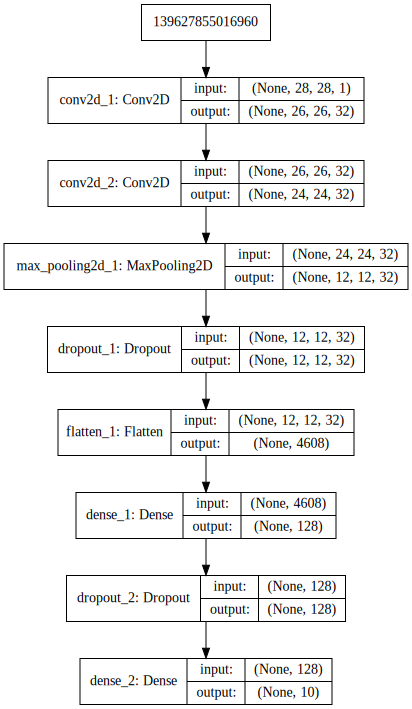

In [0]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Learning

Now let's train the CNN model. Note that we do not need the `reshape()` function as in the MLP case. 

This is a relatively complex model, so training is considerably slower than with MLPs. 

In [0]:
%%time

epochs = 5 # one epoch takes about 45 seconds

history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=2)

Epoch 1/5
 - 106s - loss: 0.0534 - acc: 0.9846
Epoch 2/5
 - 107s - loss: 0.0531 - acc: 0.9849
Epoch 3/5
 - 108s - loss: 0.0501 - acc: 0.9859
Epoch 4/5
 - 107s - loss: 0.0498 - acc: 0.9855
Epoch 5/5
 - 107s - loss: 0.0531 - acc: 0.9850
CPU times: user 17min 12s, sys: 20.9 s, total: 17min 33s
Wall time: 8min 55s


In [0]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy');

## Inference

With enough training epochs, the test accuracy should exceed 99%.  

You can compare your result with the state-of-the art [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html).  Even more results can be found [here](http://yann.lecun.com/exdb/mnist/). 

In [0]:
%%time
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

We can again take a closer look on the results. Let's begin by defining
a helper function to show the failure cases of our classifier. 

In [0]:
def show_failures(predictions, trueclass=None, predictedclass=None, maxtoshow=10):
    rounded = np.argmax(predictions, axis=1)
    errors = rounded!=y_test
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parenthesis.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(X_test.shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            if trueclass is not None and y_test[i] != trueclass:
                continue
            if predictedclass is not None and predictions[i] != predictedclass:
                continue
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            if K.image_dim_ordering() == 'th':
                plt.imshow(X_test[i,0,:,:], cmap="gray")
            else:
                plt.imshow(X_test[i,:,:,0], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], y_test[i]))
            ii = ii + 1

Here are the first 10 test digits the CNN classified to a wrong class:

In [0]:
predictions = model.predict(X_test)

show_failures(predictions)

We can use `show_failures()` to inspect failures in more detail. For example, here are failures in which the true class was "6":

In [0]:
show_failures(predictions, trueclass=6)

---
*Run this notebook in Google Colaboratory using [this link](https://colab.research.google.com/github/csc-training/intro-to-dl/blob/master/day1/keras-mnist-cnn.ipynb).*